# Example 12: Unsupervised learning

In this example, we will use KAN for unsupervised learning. Instead of trying to figure out how a target variable $y$ depends on input variables, we treat all variables on the equal footing (as input variables). Below we contruct a synthetic dataset where we have six variables $x_1, x_2, x_3, x_4, x_5, x_6$. $(x_1, x_2, x_3)$ are dependent such that $x_3={\rm exp}({\rm sin}(\pi x_1)+x_2^2)$; $(x_4,x_5)$ are dependent such that $x_5=x_4^3$. And $x_6$ is independent of all other variables. Can we use KANs to discover these dependent groups?

The idea is that we treat the problem as a classification problem. The dataset that satisfies these interdependent relations are 'positive' samples, while corrupted samples (by random permutation of features across samples) are 'negative' samples. We want to train a KAN to output 1 when it is a positive sample, and output 0 when it is a negative sample. We set the last layer activation to be Gaussian, so positive samples will have zero activation in the second to last layer, while negtive samples will have non-zero activation in the second to last layer. We can then define the relation implicitly as $g=0$ where $g$ is the activation in the second to last layer.

Intialize model and create dataset

In [43]:
from kan import KAN
import torch
import copy

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 0

model = KAN(width=[6,1,1], grid=10, k=3, seed=seed, device=device)

# create dataset


def create_dataset(train_num=500, test_num=500):
    
    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y
        
    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)
    
    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)
    
    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

dataset = create_dataset()

cpu
checkpoint directory created: ./model
saving model version 0.0


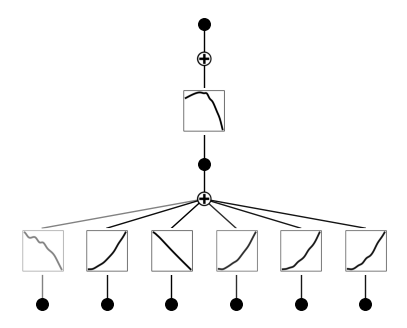

In [44]:
model(dataset['train_input'])
model.plot(beta=10)

In [45]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

saving model version 0.1


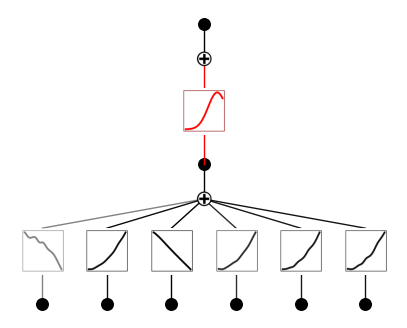

In [46]:
model(dataset['train_input'])
model.plot(beta=10)

In [47]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.01, lamb_entropy=10.0, lamb_coef=1e-7, lamb_coefdiff=1e-5)

| train_loss: 5.00e-01 | test_loss: 5.00e-01 | reg: 1.29e-02 | : 100%|█| 50/50 [00:05<00:00,  9.30it


saving model version 0.2


{'train_loss': [array(0.5001015),
  array(0.50000002),
  array(0.50000477),
  array(0.50000134),
  array(0.50000002),
  array(0.50000115),
  array(0.5000047),
  array(0.50000704),
  array(0.50000409),
  array(0.50000079),
  array(0.5),
  array(0.50000004),
  array(0.50000002),
  array(0.50000002),
  array(0.50000001),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.50000001),
  array(0.50000001),
  array(0.50000001),
  array(0.50000001),
  array(0.50000001),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5),
  array(0.5)],
 'test_loss': [array(0.50010295),
  array(0.50000002),
  array(0.50000475),
  array(0.50000132),
  array(0.50000001),
  array(0.50000115),
  array(0.50000

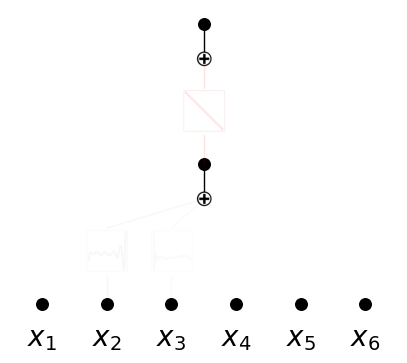

In [48]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

This gives the dependence among $(x_4,x_5)$. Another random seed can give dependence among $(x_1,x_2,x_3)$.